**This notebook provide the best practices to consume covid-lake API.**

In [1]:
# General Import

import pandas as pd
import numpy as np
import re
import seaborn as sns
from datetime import datetime


#!pip install scipy
import scipy
pearsonr = scipy.stats.pearsonr

import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
%run /home/ubuntu/notebooks/covid-prj01-data-analysis/[UTILS]/dremio-access-new.py

dremio = DremioQueryMakerJDBC()
index = dremio.getIndex()
display(index)

,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,VIEW_DEFINITION
0,DREMIO,Covid-Lake,Disease_Indicator,"SELECT createdOn, identifier, valueString, val..."
1,DREMIO,Covid-Lake,hospitalizações,"SELECT * FROM ""hospitalizacoes.csv"""
2,DREMIO,Covid-Lake,Institution,SELECT * FROM logical_entity
3,DREMIO,Covid-Lake,News&Trends,SELECT * FROM logical_entity
4,DREMIO,Covid-Lake,Socioeconomic_Factors,"SELECT createdOn, clean_data_to_FLOAT(valueStr..."
...,...,...,...,...
80,DREMIO,Common Data Model.disease_indicator.wcota.stan...,Observation,"SELECT ""date"" as createdOn, 'wcota' as identif..."
81,DREMIO,Common Data Model.Institutions.hospitals_regis...,Location,"SELECT CO_UNIDADE AS organizationId, \n ..."
82,DREMIO,Common Data Model.Institutions.hospitals_regis...,Organization,"SELECT CO_UNIDADE AS organizationId, CO_CNES A..."
83,DREMIO,Common Data Model.news_trends.google_trends.st...,Observation,"SELECT ""Date"" as createdOn, CAST(Medicamento a..."


In [3]:
list(index['TABLE_NAME'])

['Disease_Indicator',
 'hospitalizações',
 'Institution',
 'News&Trends',
 'Socioeconomic_Factors',
 'brasil_io',
 'cities',
 'fiocruz_infogripe',
 'google_trends',
 'health_ministry',
 'hospitals_dimension',
 'mobility_apple',
 'mobility_google',
 'pebmed',
 'wcota',
 'observations',
 'global_dataset',
 'demandas_dos_consumidores_nip',
 'BDCnewsCOVID',
 'treatedBDCcompanies',
 'treatedBDCpeople',
 'EDUCACAO_BASICA_DOCENTES_CO',
 'EDUCACAO_BASICA_DOCENTES_NORDESTE',
 'EDUCACAO_BASICA_DOCENTES_NORTE',
 'EDUCACAO_BASICA_DOCENTES_SUDESTE',
 'EDUCACAO_BASICA_DOCENTES_SUL',
 'EDUCACAO_BASICA_ESCOLAS',
 'EDUCACAO_BASICA_GESTOR',
 'EDUCACAO_BASICA_MATRICULA_CO',
 'EDUCACAO_BASICA_MATRICULA_NORDESTE',
 'EDUCACAO_BASICA_MATRICULA_NORTE',
 'EDUCACAO_BASICA_MATRICULA_SUDESTE',
 'EDUCACAO_BASICA_MATRICULA_SUL',
 'EDUCACAO_BASICA_TURMAS',
 'ENSINO_SUPERIOR_DM_ALUNOS',
 'cadasto_nacional_de_estabelecimentos_de_saude_cnes',
 'cadasto_nacional_de_estabelecimentos_de_saude_cnes_ativos',
 'cobertura_est

In [5]:
index_table = index['TABLE_NAME'].loc[index['TABLE_NAME'] == 'casofull'].index[0]
index_table

47

In [6]:
casos_full = dremio.getTable(index_table)
casos_full.head()

,city,city_ibge_code,date,epidemiological_week,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
0,São Paulo,3550308,2020-02-25,9,12252023.0,False,False,1,0.00816,2020-02-25,0.0,0,1,city,SP,1,0
1,,35,2020-02-25,9,45919049.0,False,False,1,0.00218,2020-02-25,0.0,0,1,state,SP,1,0
2,São Paulo,3550308,2020-02-26,9,12252023.0,False,False,1,0.00816,2020-02-26,0.0,0,2,city,SP,0,0
3,,35,2020-02-26,9,45919049.0,False,False,1,0.00218,2020-02-26,0.0,0,2,state,SP,0,0
4,São Paulo,3550308,2020-02-27,9,12252023.0,False,False,1,0.00816,2020-02-27,0.0,0,3,city,SP,0,0


In [7]:
casos_full.shape

(751472, 17)

In [4]:
index_table = index['TABLE_NAME'].loc[index['TABLE_NAME'] == 'obitos_cartorio_2019_2020'].index[0]
index_table

61

In [5]:
obitos_cartorio = dremio.getTable(index_table)
obitos_cartorio.head()

,ano,uf,tipo_doenca,local_obito,faixa_etaria(anos),sexo,total
0,2019,AC,outras,domicilio,0 - 9,F,8
1,2019,AC,outras,domicilio,0 - 9,M,15
2,2019,AC,outras,hospital,0 - 9,F,29
3,2019,AC,outras,hospital,0 - 9,M,56
4,2019,AC,outras,ignorado,0 - 9,M,1


In [6]:
obitos_cartorio.shape

(26298, 7)

In [11]:
# Rename date column
#casos_full.columns = []

## exploreEntity

Presents an overview of the tables existing in the covid-lake.

URL: http://23.20.157.201/api/exploreEntity

*Each Table represents a CDM (Common Data Model) because it encompesses a set of dataset collected from different sources and mapped following a standard enitity.*

### Let's play with Data :)

- **Analyzing casos_full dataset**

Checking all columns

In [12]:
all_columns = casos_full.columns.values.tolist()
print('Total columns:', len(all_columns))

Total columns: 17


In [13]:
all_columns

['city',
 'city_ibge_code',
 'date',
 'epidemiological_week',
 'estimated_population_2019',
 'is_last',
 'is_repeated',
 'last_available_confirmed',
 'last_available_confirmed_per_100k_inhabitants',
 'last_available_date',
 'last_available_death_rate',
 'last_available_deaths',
 'order_for_place',
 'place_type',
 'state',
 'new_confirmed',
 'new_deaths']

Verifying all NAs

In [14]:
# count NAs per column
casos_full.isna().sum()

city                                                 0
city_ibge_code                                       0
date                                                 0
epidemiological_week                                 0
estimated_population_2019                         3158
is_last                                              0
is_repeated                                          0
last_available_confirmed                             0
last_available_confirmed_per_100k_inhabitants    16296
last_available_date                                  0
last_available_death_rate                            0
last_available_deaths                                0
order_for_place                                      0
place_type                                           0
state                                                0
new_confirmed                                        0
new_deaths                                           0
dtype: int64

Dropping all NAs

In [15]:
# remove columns full of NAs
#casos_full.dropna(inplace=True)
#casos_full.head()

In [16]:
casos_full.shape

(751472, 17)

Verifying the duplicated columns

In [17]:
# drop duplicates
#casos_full.drop_duplicates() 
# no duplicates

In [18]:
casos_full.shape

(751472, 17)

Shows all the data, though it runs quite slow for big datasets

In [19]:
#force_show_all_columns(base_unif)

Describe the dataset

In [20]:
casos_full.describe()

,estimated_population_2019,last_available_confirmed_per_100k_inhabitants,last_available_death_rate,last_available_deaths,new_confirmed,new_deaths
count,7.483140e+05,735176.000000,751472.000000,751472.000000,751472.000000,751472.000000
mean,1.032686e+05,761.479865,0.038479,27.649460,12.059027,0.363779
std,1.056789e+06,1095.740891,0.103701,409.375469,155.278184,5.178624
min,7.810000e+02,0.002180,0.000000,0.000000,-6791.000000,-187.000000
25%,6.352000e+03,71.265680,0.000000,0.000000,0.000000,0.000000
50%,1.403500e+04,350.726170,0.011900,1.000000,0.000000,0.000000
75%,3.147200e+04,1029.832895,0.036100,4.000000,2.000000,0.000000
max,4.591905e+07,16640.368980,1.000000,33984.000000,30913.000000,455.000000


Describe the fields

In [21]:
list(casos_full['state'].unique())

['SP',
 'RJ',
 'ES',
 'BA',
 'DF',
 'AL',
 'MG',
 'RS',
 'GO',
 'PE',
 'PR',
 'RN',
 'SC',
 'PB',
 'AM',
 'MS',
 'SE',
 'CE',
 'AC',
 'PA',
 'TO',
 'PI',
 'AP',
 'MA',
 'MT',
 'RO',
 'RR']

In [22]:
casos_full['state'].describe()

count     751472
unique        27
top           MG
freq      101972
Name: state, dtype: object

Frequency of each state

In [23]:
# array with each count    
counts = np.unique(casos_full['state'], return_counts=True)

# dataframe
state_count = pd.DataFrame({'state': counts[0], 'freq': counts[1]})
state_count.sort_values(by=['freq'], inplace=True,ascending=False)
state_count.head()

,state,freq
10,MG,101972
25,SP,91779
22,RS,60285
4,BA,55327
17,PR,51135


Descriptive analysis

In [24]:
casos_estados = casos_full.query('place_type == "state"').copy()
casos_estados.head()

,city,city_ibge_code,date,epidemiological_week,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
1,,35,2020-02-25,9,45919049.0,False,False,1,0.00218,2020-02-25,0.0,0,1,state,SP,1,0
3,,35,2020-02-26,9,45919049.0,False,False,1,0.00218,2020-02-26,0.0,0,2,state,SP,0,0
5,,35,2020-02-27,9,45919049.0,False,False,1,0.00218,2020-02-27,0.0,0,3,state,SP,0,0
7,,35,2020-02-28,9,45919049.0,False,False,2,0.00436,2020-02-28,0.0,0,4,state,SP,1,0
9,,35,2020-02-29,9,45919049.0,False,False,2,0.00436,2020-02-29,0.0,0,5,state,SP,0,0


In [25]:
casos_cidades = casos_full.query('place_type == "city"').copy()
casos_cidades.head()

,city,city_ibge_code,date,epidemiological_week,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
0,São Paulo,3550308,2020-02-25,9,12252023.0,False,False,1,0.00816,2020-02-25,0.0,0,1,city,SP,1,0
2,São Paulo,3550308,2020-02-26,9,12252023.0,False,False,1,0.00816,2020-02-26,0.0,0,2,city,SP,0,0
4,São Paulo,3550308,2020-02-27,9,12252023.0,False,False,1,0.00816,2020-02-27,0.0,0,3,city,SP,0,0
6,São Paulo,3550308,2020-02-28,9,12252023.0,False,False,2,0.01632,2020-02-28,0.0,0,4,city,SP,1,0
8,São Paulo,3550308,2020-02-29,9,12252023.0,False,False,2,0.01632,2020-02-29,0.0,0,5,city,SP,0,0


## Graphs

In [26]:
df = casos_estados

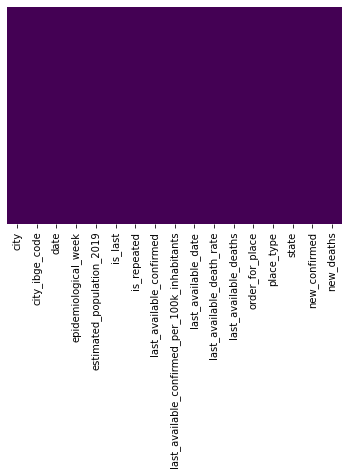

In [27]:
# Missing values
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis');

In [28]:
# For more details
display(df.isnull().sum().sort_values(ascending=False))

last_available_confirmed_per_100k_inhabitants    6
last_available_confirmed                         0
city_ibge_code                                   0
date                                             0
epidemiological_week                             0
estimated_population_2019                        0
is_last                                          0
is_repeated                                      0
new_deaths                                       0
new_confirmed                                    0
last_available_date                              0
last_available_death_rate                        0
last_available_deaths                            0
order_for_place                                  0
place_type                                       0
state                                            0
city                                             0
dtype: int64

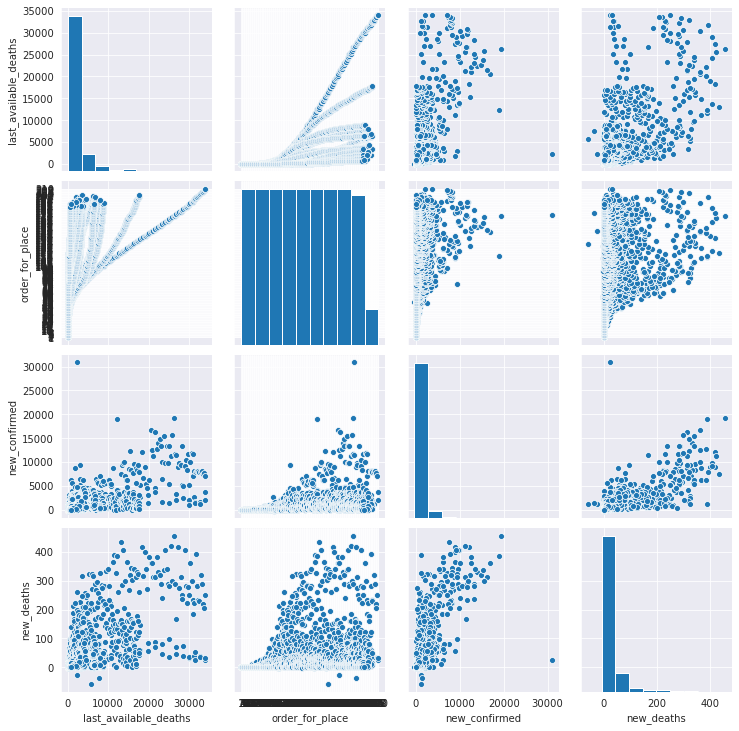

In [29]:
columns = [ 'last_available_deaths'
           ,'order_for_place'
           ,'new_confirmed'
           ,'new_deaths'
           ]
sns.set_style("darkgrid")
sns.pairplot(df[columns]);
#sns.pairplot(df[df.columns[-5:]])

### ???. Let's verify that:

In [30]:
pearson_cor = pearsonr(df.new_confirmed, df.new_deaths)
print('Pearsons correlation: %.3f' % pearson_cor[0])

Pearsons correlation: 0.755


In [31]:
pearson_cor = pearsonr(df.last_available_deaths, df.new_confirmed)
print('Pearsons correlation: %.3f' % pearson_cor[0])

Pearsons correlation: 0.652


In [32]:
pearson_cor = pearsonr(df.last_available_deaths, df.new_deaths)
print('Pearsons correlation: %.3f' % pearson_cor[0])

Pearsons correlation: 0.656


#### ???

### Unifying the date column to produce more graphs

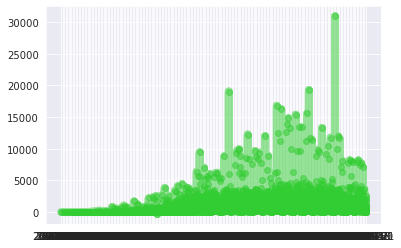

In [33]:
plt.plot(df['date'], df['new_confirmed'], color='limegreen', linewidth=8, alpha=0.5, marker='o');

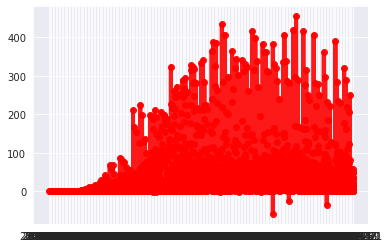

In [34]:
plt.plot(df['date'], df['new_deaths'], color='red', linewidth=4, alpha=0.9, marker='o');

In [35]:
# Unify the date column format
df['date'] = pd.to_datetime(df.date).dt.date
# Sort dates
df = df.sort_values('date')
cumulated = df.groupby('date').agg({'new_confirmed': 'sum',
                                    'new_deaths': 'sum'}).reset_index()
cumulated.head()

,date,new_confirmed,new_deaths
0,2020-02-25,1,0
1,2020-02-26,0,0
2,2020-02-27,0,0
3,2020-02-28,1,0
4,2020-02-29,0,0


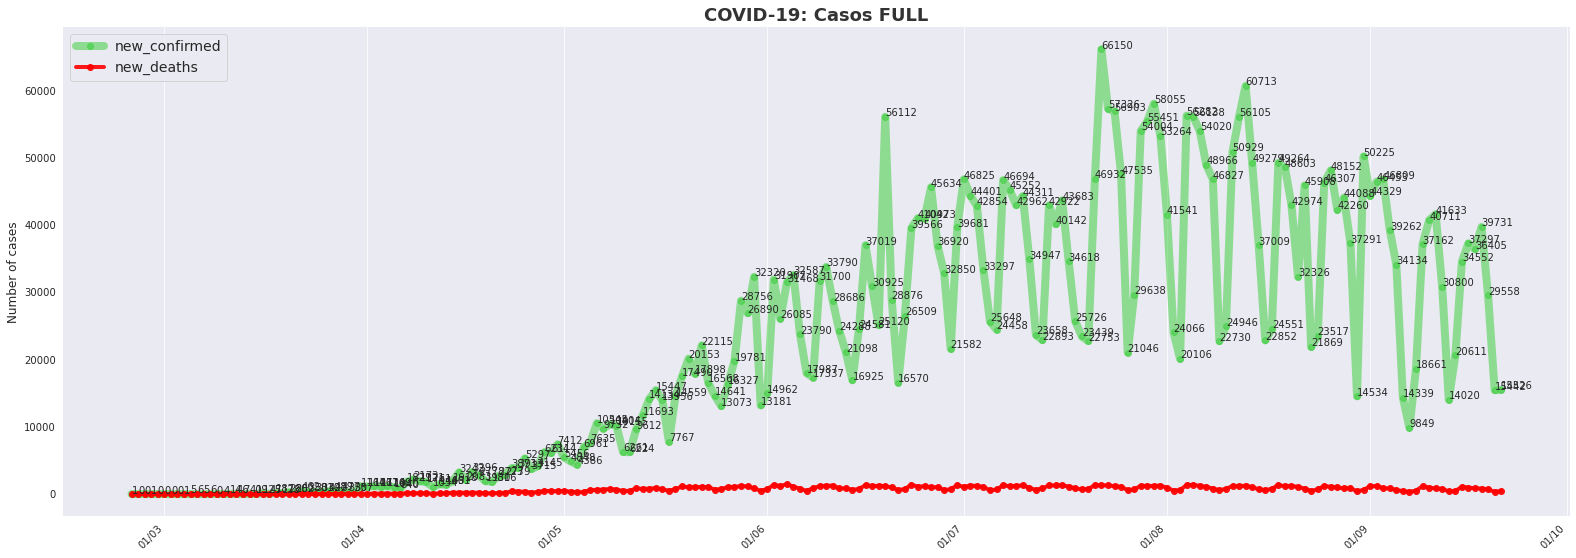

In [36]:
fig, ax = plt.subplots(figsize=(27, 9))

plt.plot(cumulated['date'], cumulated['new_confirmed'], color='limegreen', linewidth=8, alpha=0.5, marker='o')
plt.plot(cumulated['date'], cumulated['new_deaths'], color='red', linewidth=4, alpha=0.9, marker='o')


[ax.annotate('%s' % y, xy=(x,y+100), fontsize=10) for x,y in zip(cumulated['date'], cumulated['new_confirmed'])]

plt.xticks(rotation=45, ha='right')
plt.title('COVID-19: Casos FULL', fontsize=18, fontweight='bold', color='#333333')

plt.ylabel('Number of cases', fontsize=12)
plt.xlabel(None)

plt.legend(loc=2, labels=['new_confirmed','new_deaths'], fontsize=14)

plt.grid(which='major', axis='y')
[ax.spines[side].set_visible(False) for side in ['left','right','top']]
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.show();

#### The number of cases increased while the number of deaths remained basically constant.

In [37]:
np.all(np.diff(cumulated['new_confirmed']) > 0)

False

In [38]:
np.all(np.diff(cumulated['new_deaths']) > 0)

False

### Confirmed cases distribution

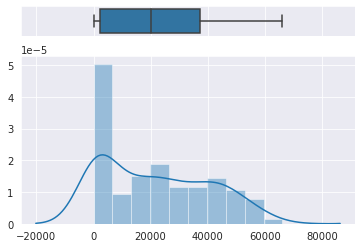

In [39]:
confirmed_cases = cumulated['new_confirmed'].values

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.set_style("darkgrid")
sns.boxplot(confirmed_cases, ax=ax_box)
sns.distplot(confirmed_cases, bins=10, ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='');

In [40]:
cumulated.new_confirmed.describe()

count      210.000000
mean     21724.347619
std      18558.805774
min          0.000000
25%       2310.500000
50%      20129.500000
75%      37258.750000
max      66150.000000
Name: new_confirmed, dtype: float64

### Death cases distribution

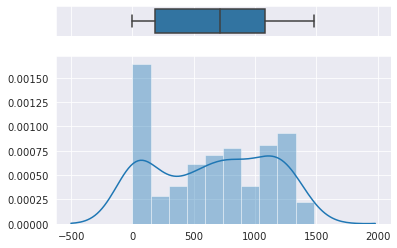

In [41]:
deaths_cases = cumulated['new_deaths'].values

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.set_style("darkgrid")
sns.boxplot(deaths_cases, ax=ax_box)
sns.distplot(deaths_cases, bins=10, ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='');

In [42]:
cumulated.new_deaths.describe()

count     210.000000
mean      654.357143
std       460.406125
min         0.000000
25%       181.000000
50%       711.500000
75%      1081.250000
max      1478.000000
Name: new_deaths, dtype: float64

## But all states are included in the data, as we can see below, so we can plot only SP data, for instance.

In [43]:
df.state.unique()

array(['SP', 'RJ', 'ES', 'BA', 'DF', 'MG', 'AL', 'RS', 'SC', 'RN', 'PE',
       'PR', 'GO', 'PB', 'AM', 'SE', 'MS', 'CE', 'AC', 'TO', 'PA', 'PI',
       'RO', 'AP', 'MT', 'MA', 'RR'], dtype=object)

In [44]:
df.head()

,city,city_ibge_code,date,epidemiological_week,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
1,,35,2020-02-25,9,45919049.0,False,False,1,0.00218,2020-02-25,0.0,0,1,state,SP,1,0
3,,35,2020-02-26,9,45919049.0,False,False,1,0.00218,2020-02-26,0.0,0,2,state,SP,0,0
5,,35,2020-02-27,9,45919049.0,False,False,1,0.00218,2020-02-27,0.0,0,3,state,SP,0,0
7,,35,2020-02-28,9,45919049.0,False,False,2,0.00436,2020-02-28,0.0,0,4,state,SP,1,0
9,,35,2020-02-29,9,45919049.0,False,False,2,0.00436,2020-02-29,0.0,0,5,state,SP,0,0


In [45]:
df.shape

(5215, 17)

In [46]:
cumulated['cumulated_confirmed'] = cumulated['new_confirmed'].cumsum()
cumulated.head()

,date,new_confirmed,new_deaths,cumulated_confirmed
0,2020-02-25,1,0,1
1,2020-02-26,0,0,1
2,2020-02-27,0,0,1
3,2020-02-28,1,0,2
4,2020-02-29,0,0,2


In [47]:
cumulated['cumulated_deaths'] = cumulated['new_deaths'].cumsum()
cumulated.head()

,date,new_confirmed,new_deaths,cumulated_confirmed,cumulated_deaths
0,2020-02-25,1,0,1,0
1,2020-02-26,0,0,1,0
2,2020-02-27,0,0,1,0
3,2020-02-28,1,0,2,0
4,2020-02-29,0,0,2,0


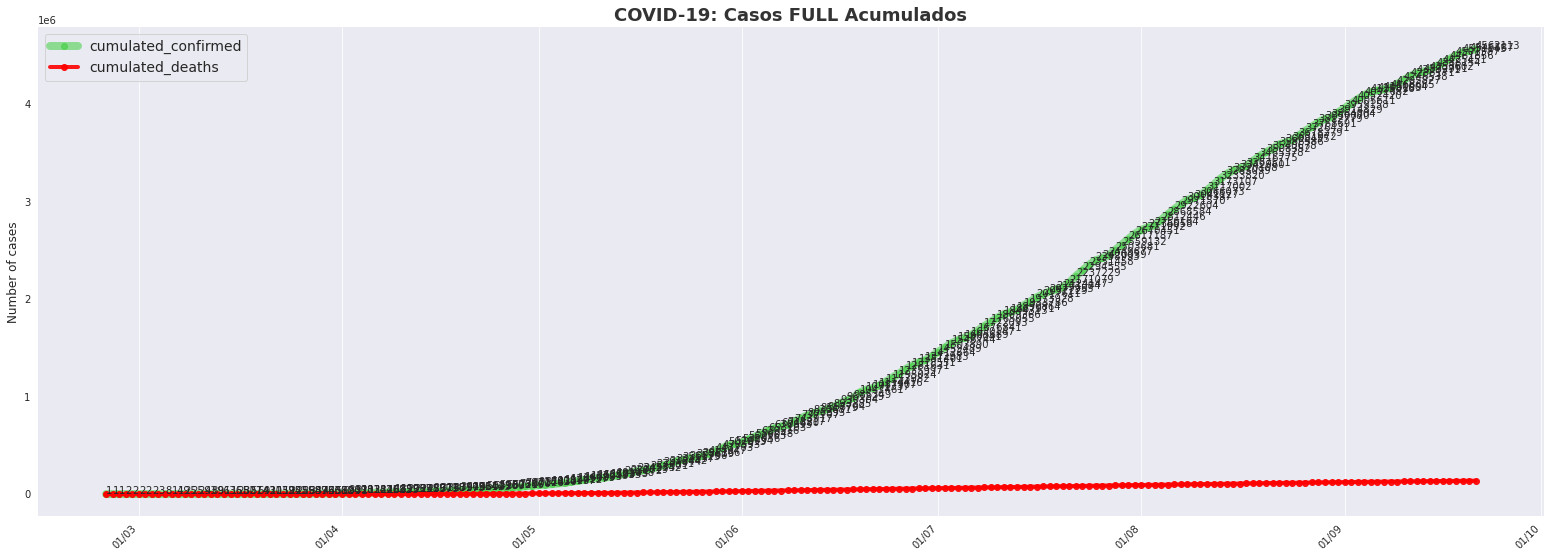

In [48]:
fig, ax = plt.subplots(figsize=(27, 9))

plt.plot(cumulated['date'], cumulated['cumulated_confirmed'], color='limegreen', linewidth=8, alpha=0.5, marker='o')
plt.plot(cumulated['date'], cumulated['cumulated_deaths'], color='red', linewidth=4, alpha=0.9, marker='o')


[ax.annotate('%s' % y, xy=(x,y+100), fontsize=10) for x,y in zip(cumulated['date'], cumulated['cumulated_confirmed'])]

plt.xticks(rotation=45, ha='right')
plt.title('COVID-19: Casos FULL Acumulados', fontsize=18, fontweight='bold', color='#333333')

plt.ylabel('Number of cases', fontsize=12)
plt.xlabel(None)

plt.legend(loc=2, labels=['cumulated_confirmed','cumulated_deaths'], fontsize=14)

plt.grid(which='major', axis='y')
[ax.spines[side].set_visible(False) for side in ['left','right','top']]
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.show();

# Analyzing state by state

In [49]:
def state_chart (df, estado):
    df = df
    estado = estado
    title = 'COVID-19 in ' + estado + ': Casos FULL data source'

    df = df.query('state == @estado').copy()

    df['date'] = pd.to_datetime(df.date).dt.date
    df = df.sort_values('date')
    cumulated = df.groupby('date').agg({'new_confirmed': 'sum',
                                        'new_deaths': 'sum'}).reset_index()
    cumulated['cumulated_confirmed'] = cumulated['new_confirmed'].cumsum()
    cumulated['cumulated_deaths'] = cumulated['new_deaths'].cumsum()

    fig, ax = plt.subplots(figsize=(27, 9))

    plt.plot(cumulated['date'], cumulated['cumulated_confirmed'], color='limegreen', linewidth=8, alpha=0.5, marker='o')
    plt.plot(cumulated['date'], cumulated['cumulated_deaths'], color='red', linewidth=4, alpha=0.9, marker='o')


    [ax.annotate('%s' % y, xy=(x,y+100), fontsize=10) for x,y in zip(cumulated['date'], cumulated['cumulated_confirmed'])]

    plt.xticks(rotation=45, ha='right')
    plt.title(title, fontsize=18, fontweight='bold', color='#333333')

    plt.ylabel('Number of cases', fontsize=12)
    plt.xlabel(None)

    plt.legend(loc=2, labels=['cumulated_confirmed','cumulated_deaths'], fontsize=14)

    plt.grid(which='major', axis='y')
    [ax.spines[side].set_visible(False) for side in ['left','right','top']]
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
    return plt.show()

### Plotting only SP state data

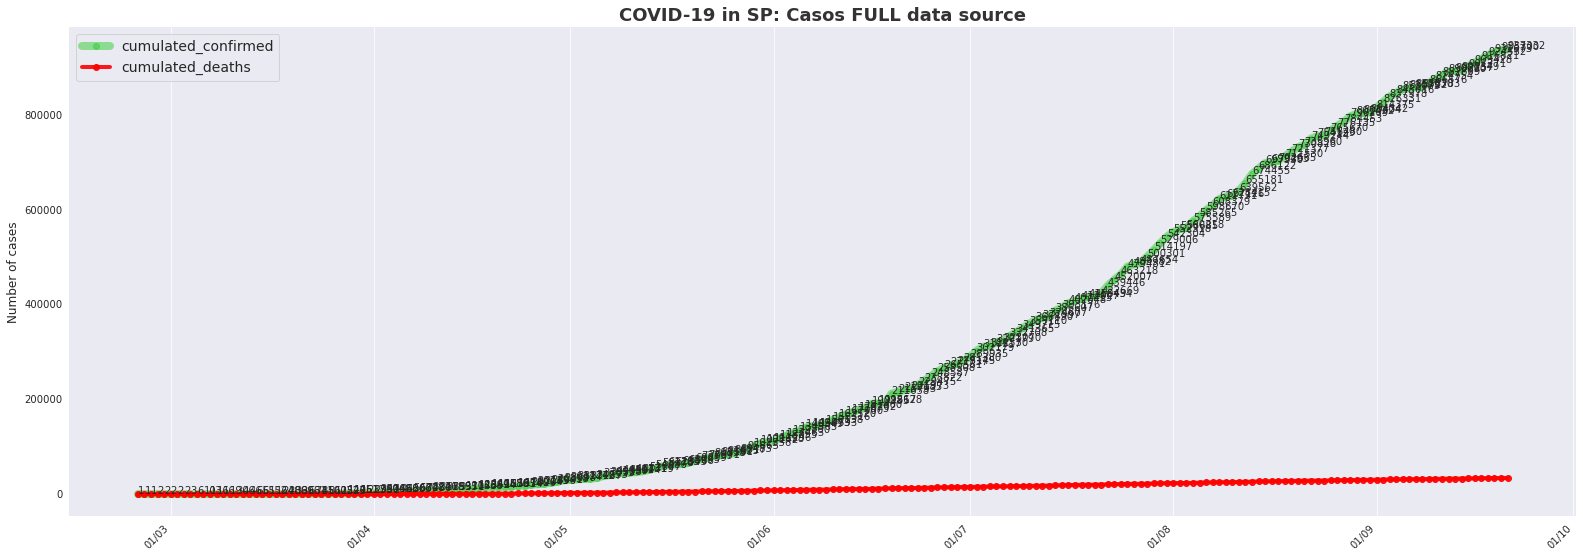

In [50]:
state_chart(casos_estados,'SP')

### Plotting only RJ state data

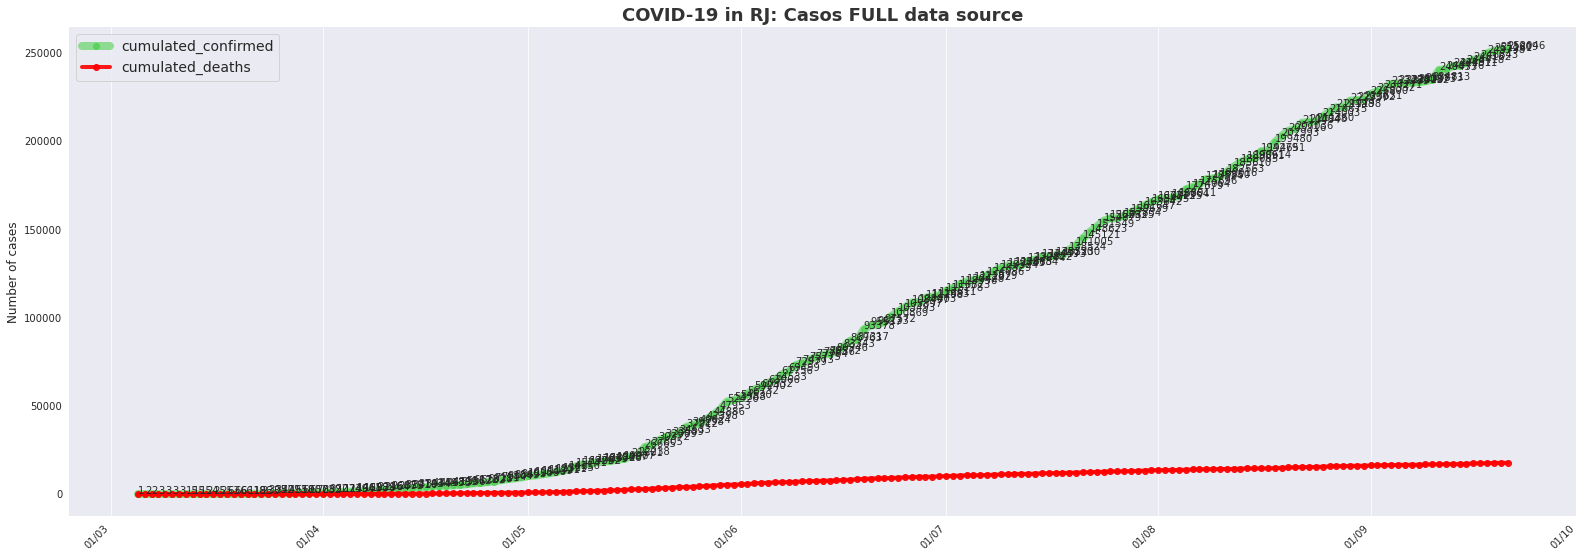

In [51]:
state_chart(casos_estados,'RJ')

### Plotting only MG state data

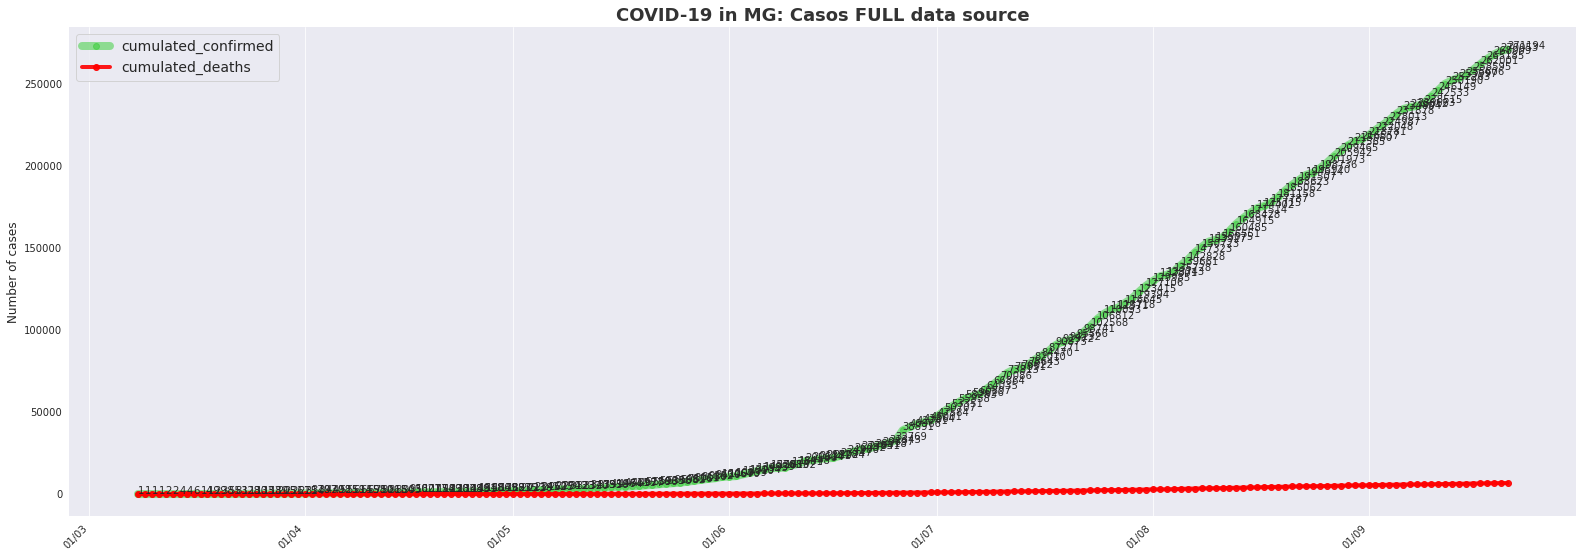

In [52]:
state_chart(casos_estados,'MG')

### Plotting only AM state data

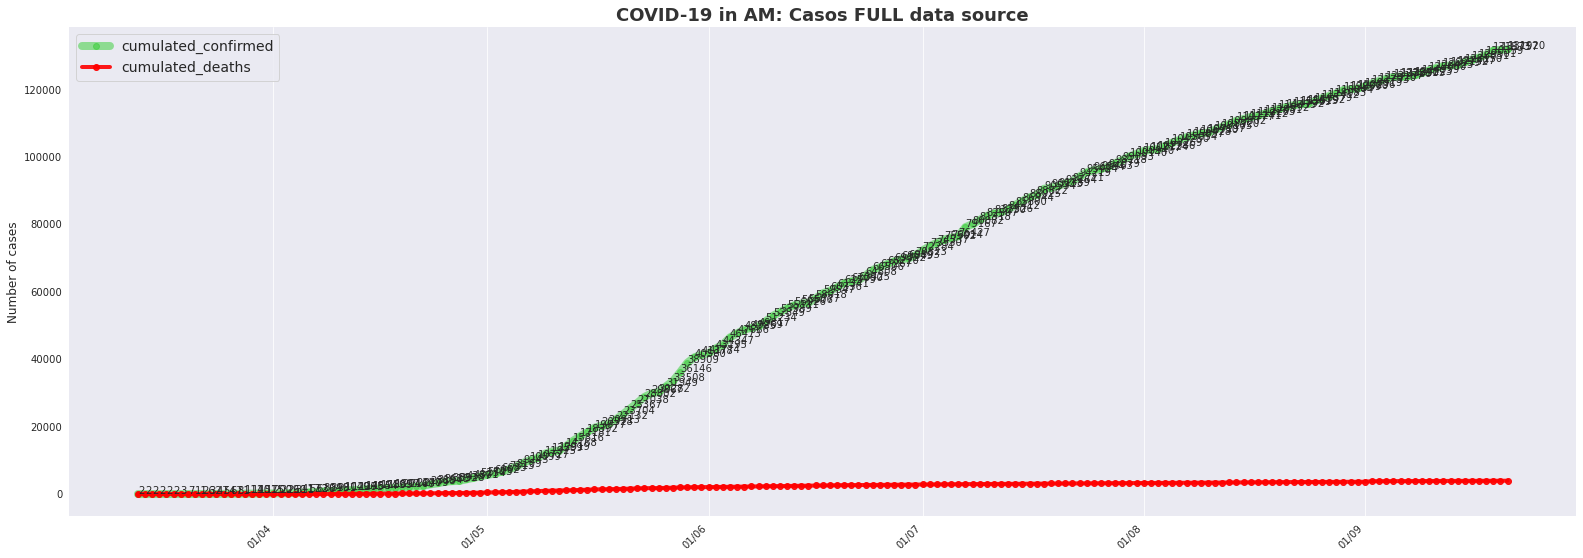

In [53]:
state_chart(casos_estados,'AM')

### Plotting only BA state data

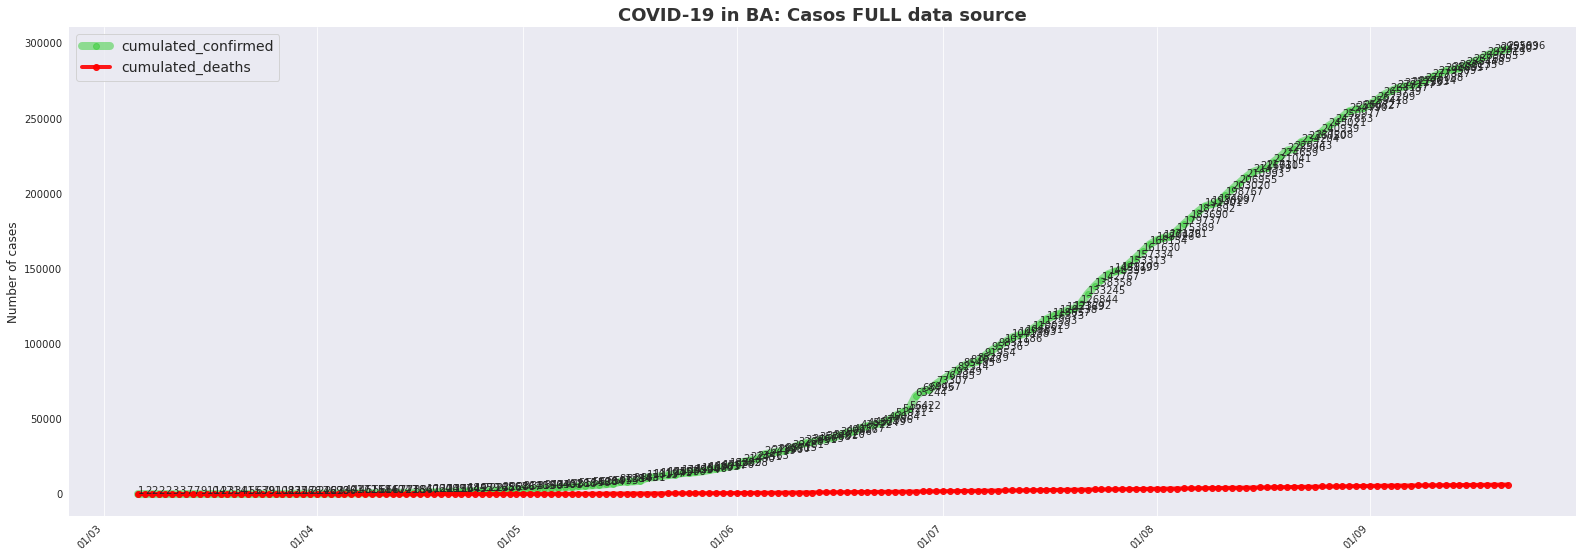

In [54]:
state_chart(casos_estados,'BA')

# Comparative analysis of the state with the capital

In [77]:
def comparative_chart (df_state, state, df_city, city, model):
    df_state = df_state
    state = state
    df_city = df_city
    city = city
    model = model

    df_state = df_state.query('state == @state').copy()

    df_state['date'] = pd.to_datetime(df_state.date).dt.date
    df_state = df_state.sort_values('date')
    cumulated_state = df_state.groupby('date').agg({'new_confirmed': 'sum',
                                        'new_deaths': 'sum'}).reset_index()
    cumulated_state['cumulated_confirmed'] = cumulated_state['new_confirmed'].cumsum()
    cumulated_state['cumulated_deaths'] = cumulated_state['new_deaths'].cumsum()
    
    df_city = df_city.query('city == @city').copy()

    df_city['date'] = pd.to_datetime(df_city.date).dt.date
    df_city = df_city.sort_values('date')
    cumulated_city = df_city.groupby('date').agg({'new_confirmed': 'sum',
                                        'new_deaths': 'sum'}).reset_index()
    cumulated_city['cumulated_confirmed'] = cumulated_city['new_confirmed'].cumsum()
    cumulated_city['cumulated_deaths'] = cumulated_city['new_deaths'].cumsum()
    
    if model == 'deaths':

        title = 'COVID-19 comparative ' + state + ' X ' + city +': deaths'

        fig, ax = plt.subplots(figsize=(27, 9))

        plt.plot(cumulated_state['date'], cumulated_state['cumulated_deaths'], color='limegreen', linewidth=8, alpha=0.5, marker='o')
        plt.plot(cumulated_city['date'], cumulated_city['cumulated_deaths'], color='red', linewidth=4, alpha=0.9, marker='o')

        #[ax.annotate('%s' % y, xy=(x,y+100), fontsize=10) for x,y in zip(cumulated_state['date'], cumulated_state['cumulated_deaths'])]

        plt.xticks(rotation=45, ha='right')
        plt.title(title, fontsize=18, fontweight='bold', color='#333333')

        plt.ylabel('Number of cases', fontsize=12)
        plt.xlabel(None)

        plt.legend(loc=2, labels=['cumulated_deaths_state','cumulated_deaths_city'], fontsize=14)

        plt.grid(which='major', axis='y')
        [ax.spines[side].set_visible(False) for side in ['left','right','top']]
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
        return plt.show()
    
    elif model == 'confirmed':

        title = 'COVID-19 comparative ' + state + ' X ' + city +': confirmed'

        fig, ax = plt.subplots(figsize=(27, 9))

        plt.plot(cumulated_state['date'], cumulated_state['cumulated_confirmed'], color='limegreen', linewidth=8, alpha=0.5, marker='o')
        plt.plot(cumulated_city['date'], cumulated_city['cumulated_confirmed'], color='red', linewidth=4, alpha=0.9, marker='o')

        #[ax.annotate('%s' % y, xy=(x,y+100), fontsize=10) for x,y in zip(cumulated_state['date'], cumulated_state['cumulated_deaths'])]

        plt.xticks(rotation=45, ha='right')
        plt.title(title, fontsize=18, fontweight='bold', color='#333333')

        plt.ylabel('Number of cases', fontsize=12)
        plt.xlabel(None)

        plt.legend(loc=2, labels=['cumulated_confirmed_state','cumulated_confirmed_city'], fontsize=14)

        plt.grid(which='major', axis='y')
        [ax.spines[side].set_visible(False) for side in ['left','right','top']]
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
        return plt.show()
    
    else:
        print('Invalid parameters')

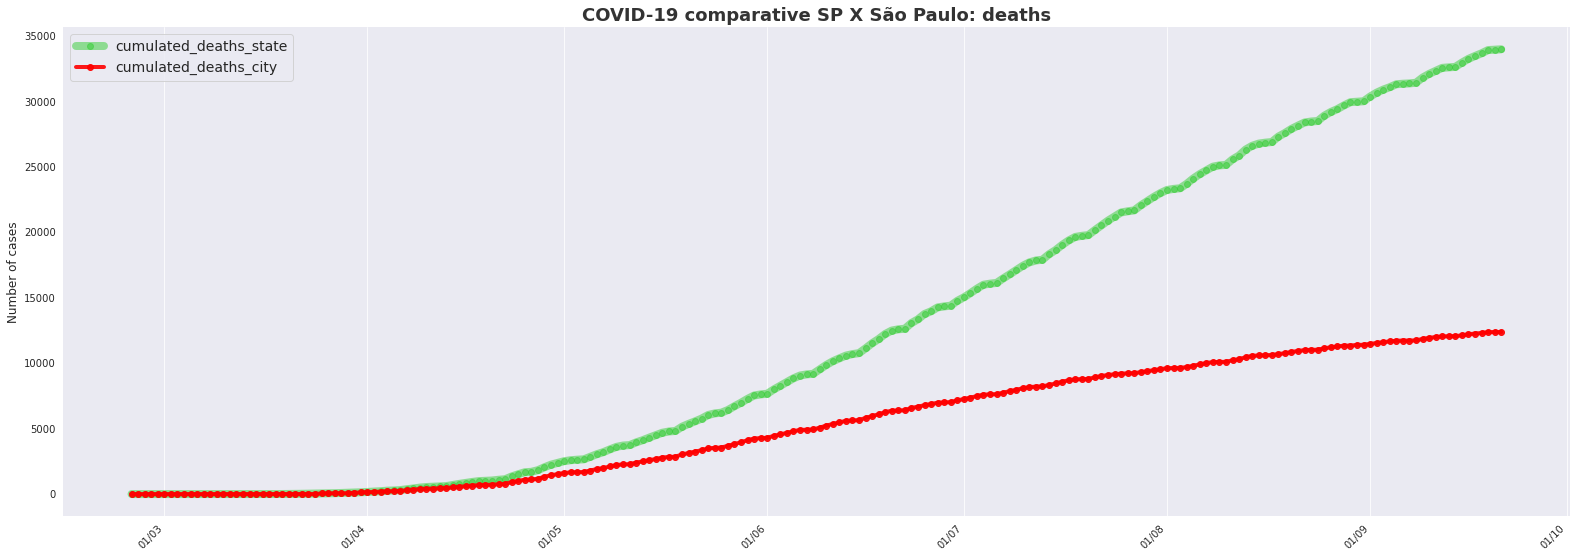

In [79]:
comparative_chart (casos_estados, 'SP', casos_cidades, 'São Paulo', 'deaths')

### Conclusion

#### ???

## *Developed by*

 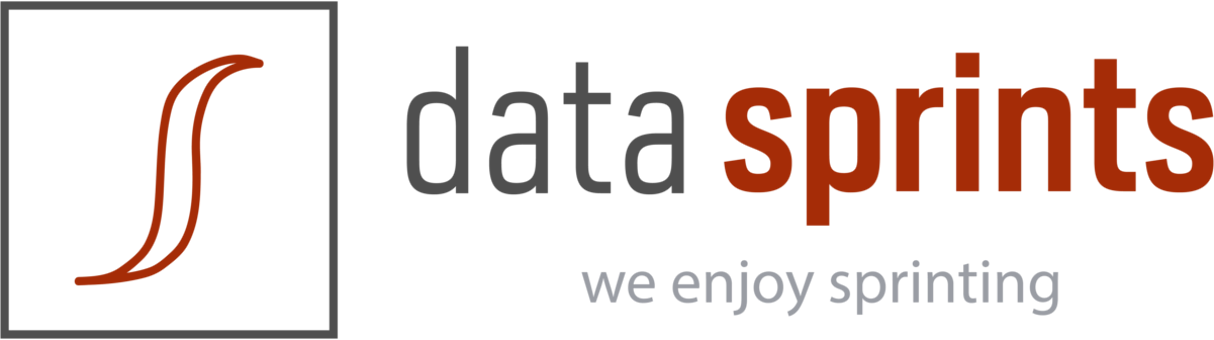